In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import PIL
import numpy as np
import matplotlib.pylab as plt
import os

%matplotlib inline

In [3]:
import modules.custom_transformers as custom_transformers

## TODO \#2: Make a transform that turns the image into a 4d block

### 27 channels (9 basis functions * 3 original channels) x scale x height x width


In [4]:
trainset_ycbcr = torchvision.datasets.CIFAR10(
    root='./image_files',
    train=True,
    download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        custom_transformers.ToYCbYr()
    ])
)
trainloader_ycbcr = torch.utils.data.DataLoader(trainset_ycbcr, batch_size=16, shuffle=False, num_workers=0)
gen_ycbcr = iter(trainloader_ycbcr)
images_cpu_ycbcr, labels_cpu_ycbcr = next(gen_ycbcr)

In [5]:
def make_bases(length, num_bases):
    xs = torch.tensor(range(length)).type(torch.FloatTensor)
    bases = [
        torch.cos(np.pi * p * (2. * xs + 1) / (2 * length))
        for p in range(num_bases)
    ]

    def mesh_bases(b1, b2):
        rr, cc = torch.meshgrid([b1, b2])
        return rr * cc

    full_bases = torch.stack([
        mesh_bases(b1, b2)
        for b1 in bases
        for b2 in bases
    ])
    return full_bases


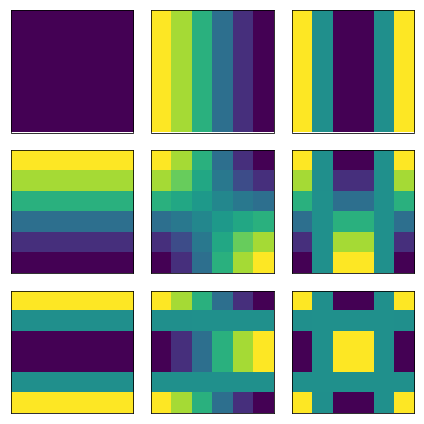

------------------------------------------------------------


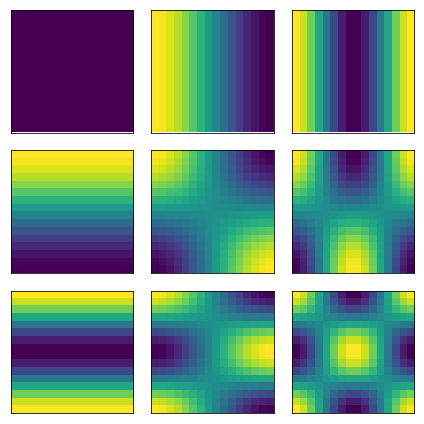

------------------------------------------------------------


In [6]:
num_bases = 3
for length in [6, 16]:
    fig, axes = plt.subplots(
        num_bases, num_bases,
        subplot_kw={'xticks': [], 'yticks': []},
        figsize=(6, 6)
    )
    bases = make_bases(length, num_bases)
    for i, ax in enumerate(axes.flat):
        ax.imshow(bases[i])
    plt.tight_layout()
    plt.show()
    print('-' * 60)


In [8]:
bases.shape

torch.Size([9, 16, 16])

In [9]:
images_cpu_ycbcr.shape

torch.Size([16, 3, 32, 32])

In [34]:
bases.repeat(3,1,1).unsqueeze(1).shape

torch.Size([27, 1, 16, 16])

In [37]:
repeated_bases = bases.repeat(3,1,1).unsqueeze(1)

In [49]:
repeated_bases.shape

torch.Size([27, 1, 16, 16])

output width = input width + left padding + right padding - kernel width + 1

input width = bases.shape\[-1\]

kernel width = repeated_bases.shape\[-1\]

want output width = input width

padding should be (kernel width - 1)/2

if that's an even number, then:

output width = input width + 2*(kernel width - 1)/2  - kernel width + 1 = input width

if kernel width is even, then use

left padding = kernel width / 2 - 1

right padding = kernel width / 2

then:

output width = input width + (kernel width / 2 - 1) + (kernel width / 2) - kernel width + 1

= input width + kernel width - 1 - kernel width + 1

= input width


in all cases, want left_padding + right_padding - kernel width + 1 == 0

so given left_padding, set right_padding = kernel width - 1 - left_padding

In [50]:
left_padding = (repeated_bases.shape[-1] - 1) // 2
right_padding = repeated_bases.shape[-1] - 1 - left_padding
top_padding = (repeated_bases.shape[-2] - 1) // 2
bottom_padding = repeated_bases.shape[-2] - 1 - top_padding
images_padded = F.pad(images_cpu_ycbcr, (left_padding, right_padding, top_padding, bottom_padding))

In [67]:
maybe_convolved = F.conv2d(
    input=images_padded,
    weight=repeated_bases,
    groups=3
)

In [68]:
maybe_convolved.shape

torch.Size([16, 27, 32, 32])

In [46]:
images_cpu_ycbcr[0,1,:16,:16].sum()

tensor(-23.3230)

In [71]:
maybe_convolved.shape

torch.Size([16, 27, 32, 32])

In [63]:
bases_2 = make_bases(6, 3)

In [64]:
repeated_bases_2 = bases_2.repeat(3,1,1).unsqueeze(1)

In [65]:
left_padding_2 = (repeated_bases_2.shape[-1] - 1) // 2
right_padding_2 = repeated_bases_2.shape[-1] - 1 - left_padding_2
top_padding_2 = (repeated_bases_2.shape[-2] - 1) // 2
bottom_padding_2 = repeated_bases_2.shape[-2] - 1 - top_padding_2
images_padded_2 = F.pad(images_cpu_ycbcr, (left_padding_2, right_padding_2, top_padding_2, bottom_padding_2))

In [69]:
maybe_convolved_2 = F.conv2d(
    input=images_padded_2,
    weight=repeated_bases_2,
    groups=3
)

In [70]:
maybe_convolved_2.shape

torch.Size([16, 27, 32, 32])

In [78]:
maybe_convolved.mean(dim=(0,2,3))

tensor([ 8.5268e+01,  1.7725e+00, -4.8619e+00,  2.1550e+00, -7.8526e-02,
        -1.1023e-01, -5.2472e+00, -1.0042e-01,  2.9562e-01, -4.4291e+00,
        -5.6027e-02,  2.6469e-01,  4.3367e-01,  2.0763e-02, -3.0480e-02,
         2.3617e-01,  7.0192e-03, -1.4265e-02,  1.1787e+00,  1.0140e-01,
        -2.7269e-02, -3.3028e-01, -1.5929e-02,  2.1252e-02,  4.2730e-03,
        -5.5226e-03,  1.6332e-04])

In [79]:
maybe_convolved_2.mean(dim=(0,2,3))

tensor([ 1.4311e+01,  1.9299e-01, -2.7804e-01,  2.1758e-01,  2.3280e-05,
        -3.3913e-03, -2.9845e-01, -3.8624e-03,  5.7058e-03, -7.3763e-01,
        -7.4381e-03,  1.4896e-02,  2.3463e-02,  5.7672e-04, -5.5446e-04,
         1.2201e-02,  1.3347e-04, -2.2177e-04,  1.6876e-01,  4.4634e-03,
        -1.0780e-04, -2.1581e-02, -4.9197e-04,  4.9137e-04,  2.0269e-03,
        -1.9763e-05, -4.0686e-05])

In [80]:
torch.stack([
    maybe_convolved,
    maybe_convolved_2,
], dim=2).shape

torch.Size([16, 27, 2, 32, 32])

In [83]:
class StackDCTs(nn.Module):
    
    @staticmethod
    def make_bases(length, num_bases):
        xs = torch.tensor(range(length)).type(torch.FloatTensor)
        bases = [
            torch.cos(np.pi * p * (2. * xs + 1) / (2 * length))
            for p in range(num_bases)
        ]

        def mesh_bases(b1, b2):
            rr, cc = torch.meshgrid([b1, b2])
            return rr * cc

        full_bases = torch.stack([
            mesh_bases(b1, b2)
            for b1 in bases
            for b2 in bases
        ])
        return full_bases

    def __init__(self, num_bases, lengths):
        super(StackDCTs, self).__init__()
        self.num_bases = num_bases
        self.lengths = lengths.copy()
        for length in self.lengths:
            buffer_name = 'basis_convolution_weights_{0}'.format(length)
            self.register_buffer(
                buffer_name,
                StackDCTs.make_bases(length, num_bases).repeat(3,1,1).unsqueeze(1)
            )
        
        

In [92]:
sd = StackDCTs(3, [4, 5])

In [87]:
sd.basis_convolution_weights_4.dtype

torch.float32

In [94]:
sd.to('cuda')

StackDCTs()

In [97]:
sd.basis_convolution_weights_5.shape

torch.Size([27, 1, 5, 5])